In [1]:
# 107062566 黃鈺程 CVLab, Delta 722
# Dependencies: numpy, pandas, matplotlib, seaborn, sklearn=0.20

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
df = pd.read_csv('./data/playground/train.csv')
df.columns = ['x', 'y', 'c']
xt = df[['x', 'y']]
yt = df['c']

df = pd.read_csv('./data/playground/test.csv')
df.columns = ['x', 'y', 'c']
xv = df[['x', 'y']]
yv = df['c']

lbl = LabelEncoder().fit(yt)
yt = lbl.transform(yt)
yv = lbl.transform(yv)

In [4]:
# KNN

pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('std', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

params_grid = {
    'pca__n_components': [1, 2],
    'clf__n_neighbors': [1, 5, 10, 15, 20],
}

grid = GridSearchCV(pipe, params_grid, scoring='accuracy', cv=4, iid=False, n_jobs=2)
grid.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 0.8902439024390244
Test Acc: 0.7783783783783784
{'clf__n_neighbors': 5, 'pca__n_components': 2}


In [5]:
# SVC

pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('std', StandardScaler()),
    ('clf', SVC())
])

params_grid = {
    'pca__n_components': [1, 2],
    'clf__kernel': ['rbf', 'sigmoid', 'linear'],
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__gamma': [0.01, 0.1, 1.0, 10.0]
}

grid = GridSearchCV(pipe, params_grid, scoring='accuracy', cv=4, iid=False, n_jobs=2)
grid.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 0.8997289972899729
Test Acc: 0.8
{'clf__C': 1.0, 'clf__gamma': 10.0, 'clf__kernel': 'rbf', 'pca__n_components': 2}


In [6]:
pipe = Pipeline(steps=[
    ('clf', RandomForestClassifier())
])

params_grid = {
    'clf__n_estimators': [10, 50, 100, 200],
    'clf__criterion': ['entropy', 'gini'],
    'clf__max_depth': [None, 1, 10, 100, 200],
}

grid = GridSearchCV(pipe, params_grid, scoring='accuracy', cv=4, iid=False, n_jobs=2)
grid.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 1.0
Test Acc: 0.8
{'clf__criterion': 'entropy', 'clf__max_depth': 100, 'clf__n_estimators': 100}


In [7]:
# Voting of Logistic, KNN, Decision

log_pipe = Pipeline(steps=[
    ('std', StandardScaler()),
    ('clf', LogisticRegression(solver='lbfgs', multi_class='auto')),
])
knn_pipe = Pipeline(steps=[
    ('pca', PCA()),
    ('std', StandardScaler()),
    ('clf', KNeighborsClassifier())
])
dec_pipe = Pipeline(steps=[
    ('clf', DecisionTreeClassifier())
])
estimators = [
    ('log', log_pipe), 
    ('knn', knn_pipe),
    ('dec', dec_pipe)
]

pipe = Pipeline(steps=[
    ('vot', VotingClassifier(estimators=estimators)),
])
params_grid = {
    'vot__voting': ['hard', 'soft'],
    'vot__weights': [(a, b, c) for a in range(3) for b in range(3) for c in range(3) if a + b + c > 0]
}

grid = GridSearchCV(pipe, params_grid, scoring='accuracy', cv=4, iid=False, n_jobs=2)
grid.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 0.9552845528455285
Test Acc: 0.7891891891891892
{'vot__voting': 'soft', 'vot__weights': (2, 2, 1)}


In [8]:
dec = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=dec, n_estimators=500, 
                        max_samples=0.6, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=2, random_state=1)
bag.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 0.9552845528455285
Test Acc: 0.7891891891891892
{'vot__voting': 'soft', 'vot__weights': (2, 2, 1)}


In [9]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

params_grid = {
    'base_estimator__max_depth': [None, 1, 10, 50, 100],
    'n_estimators': [10, 100, 500]
}

grid = GridSearchCV(ada, params_grid, scoring='accuracy', cv=4, iid=False, n_jobs=2, return_train_score=False)
grid.fit(xt, yt)

train_acc = grid.score(xt, yt)
test_acc = grid.score(xv, yv)

print('Train Acc:', train_acc)
print('Test Acc:', test_acc)
print(grid.best_params_)

Train Acc: 1.0
Test Acc: 0.827027027027027
{'base_estimator__max_depth': 10, 'n_estimators': 500}


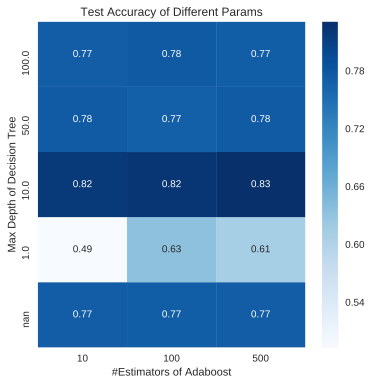

In [10]:
data = pd.DataFrame(grid.cv_results_)
df = data.pivot(index='param_base_estimator__max_depth', columns='param_n_estimators', values='mean_test_score')
fig, ax = plt.subplots(dpi=100, figsize=(6, 6))
sns.heatmap(data=df, ax=ax, annot=True, cmap=plt.cm.Blues)
ax.set_xlabel('#Estimators of Adaboost')
ax.set_ylabel('Max Depth of Decision Tree')
ax.set_title('Test Accuracy of Different Params')
ax.invert_yaxis()
plt.show()

# Conclusion

想不到結果最好的是 Adaboost，而從上圖來看，超參數對 Adaboost 影響真的很大。
如果我一開始選了不好的超參數，例如 500 & 1.0（預設參數），我還會以為這個 Classifier 不太適合這個 dataset。
但事實上是可以透過調參得到非常好的結果。